Plots to add in the intro to explain the concepts.

We want to explain the Chebyshev scalarization


/tmp/ipykernel_2318115/1979264486.py:24: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}\usepackage{bm}"]


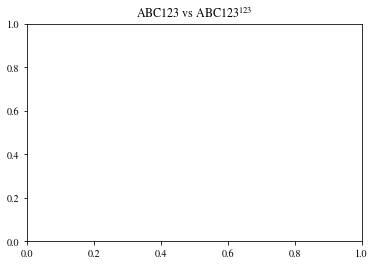

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import Tensor
from torch.distributions import MultivariateNormal
from botorch.acquisition.risk_measures import VaR
from botorch.acquisition.multi_objective.multi_output_risk_measures import MVaR
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from botorch.test_functions import Levy
from botorch.utils.transforms import unnormalize
from botorch.models.transforms.input import InputPerturbation
from botorch.utils.sampling import draw_sobol_samples, draw_sobol_normal_samples
from botorch.acquisition.multi_objective.multi_output_risk_measures import MVaR
# matplotlib.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
# matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}\usepackage{bm}"]
import seaborn as sns
torch.manual_seed(0)
n_w = 200
alpha = 0.9
cmap = "viridis"
weights = torch.tensor([0.69, 0.31])

def simple_ch_scalarization(Y: Tensor, w: Tensor) -> Tensor:
    r"""Returns min_i Y_i w_i. Dimension stays the same."""
    return torch.min(Y * w, dim=-1, keepdim=True).values


tkwargs = {"dtype": torch.double}

In [2]:
def func(x):
    p1 = 2.4 - 10 * x - 0.1*x.pow(2)
    p2 = 2 * x - 0.1*x.pow(2)
    break_point = 0.2
    smoother = (x - 0.5).pow(2) + torch.sin(30 * x) * 0.1
    x_mask = torch.sigmoid((break_point - x)/0.005)
    return (p1 * x_mask + p2 * (1-x_mask) + smoother).view(-1) *30 -30


levy = Levy().to(**tkwargs)

def modified_levy(X):
    X = torch.cat(
        [X, torch.zeros_like(X)], dim=-1,
    )
    # Cut out the first part of the function.
    X = X * 0.95 + 0.03
    X = unnormalize(X, levy.bounds)
    Y = levy(X)
    Y -= X[:, 0].pow(2) * 0.75
    return Y.view(-1)

def eval_problem(X):
    f1 = -func(X)
    f2 = modified_levy(X)
    return torch.stack([f1,f2], dim=-1)

In [3]:
x = torch.tensor([[0.4424]],**tkwargs)
standard_bounds=torch.zeros(2,1,**tkwargs)
standard_bounds[0] = 0.00
standard_bounds[1] = 0.7
std_dev = 0.1
n_w = 64
perturbation_set = draw_sobol_normal_samples(d=1, n=n_w, **tkwargs) * std_dev
intf_eval = InputPerturbation(
    perturbation_set=perturbation_set, bounds=standard_bounds
).eval()
robust_eval_x = intf_eval(x)
raw_outcomes = eval_problem(robust_eval_x)
samples = raw_outcomes.view(-1,2)

In [4]:
var_call = VaR(n_w=n_w, alpha=alpha)
indep_var = var_call(samples.t().unsqueeze(-1))

mvar_call = MVaR(n_w=n_w, alpha=alpha)
mvar_set = mvar_call(samples)
v = var_call(simple_ch_scalarization(samples, weights)).view(1) 
scalarized_var = v / weights

In [5]:
sns_cmap = sns.color_palette("viridis", as_cmap=True)
pal = sns.color_palette("viridis", as_cmap=False, n_colors=10)
pal


[(0.283072, 0.130895, 0.449241),
 (0.262138, 0.242286, 0.520837),
 (0.220057, 0.343307, 0.549413),
 (0.177423, 0.437527, 0.557565),
 (0.143343, 0.522773, 0.556295),
 (0.119512, 0.607464, 0.540218),
 (0.166383, 0.690856, 0.496502),
 (0.319809, 0.770914, 0.411152),
 (0.525776, 0.833491, 0.288127),
 (0.762373, 0.876424, 0.137064)]

In [6]:
fontdict={'fontsize': 18}

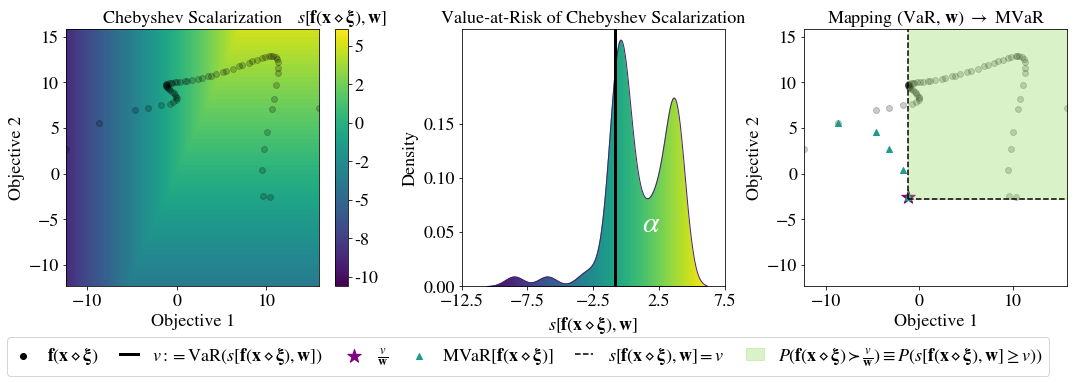

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5.4), 
                         gridspec_kw={"width_ratios": [6,5,5]})
ax = axes[0]


color = "orange"


min_s, max_s = samples.min(), samples.max()
x = torch.linspace(min_s, max_s, 100)
xx, yy = torch.meshgrid([x, x])
xy = torch.cat([xx.unsqueeze(-1), yy.unsqueeze(-1)], dim=-1)


sample_scalarizations = simple_ch_scalarization(samples, weights).squeeze()
scalarizations = sample_scalarizations
kdeplot = sns.kdeplot(scalarizations.view(-1).numpy(), fill=True, ax=axes[1], color=pal[0], alpha=0, bw_adjust=0.65)
p = kdeplot.collections[0].get_paths()[0]
vert = p.vertices
lx = np.array([vert[r][0] for r in range(len(vert))])
mask = lx >= v.item()
dxs = lx[1:]-lx[:-1]
ly = np.array([vert[r][1] for r in range(len(vert))])
colors = np.array(sns_cmap((lx-lx.min())/(lx.max()-lx.min())))
polygon = plt.fill_between(lx, np.zeros_like(lx), ly, lw=0, color='none')
import matplotlib.colors as colors
import matplotlib.cm as cmx
cNorm = colors.Normalize(vmin=lx.min(), vmax=lx.max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
cb = plt.colorbar(scalarMap, ax=axes[0])

scalarizations = simple_ch_scalarization(xy, weights).squeeze()
min_scalar = scalarizations.min().item()
max_scalar = scalarizations.max().item()
c = ax.contourf(xx, yy, scalarizations, levels=100, cmap=cmap, norm=cNorm)
sample_scalarizations = simple_ch_scalarization(samples, weights).squeeze()
scalarizations = sample_scalarizations

ax.scatter(
        samples[:, 0], 
        samples[:, 1], 
        label=r"${\bf f} ({\bf x} \diamond {\bf \xi})$",
        alpha=0.2, 
        color='k',
    )

ax.set_ylabel(r"Objective 2", **fontdict)
axes[0].set_xlabel(r"Objective 1", **fontdict)
ax = axes[1]

axes[1].set_ylabel("Density", **fontdict)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
verts = np.vstack([p.vertices for p in polygon.get_paths()])
gradient = ax.imshow(
    np.linspace(min_scalar,max_scalar, 256).reshape(1, -1), 
    cmap='viridis', 
    aspect='auto',
    extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()],
    vmin=min_scalar, 
    vmax=max_scalar,
)
gradient.set_clip_path(polygon.get_paths()[0], transform=ax.transData)
ax.text(1.2, 0.05, r"$\alpha$", color='w', fontdict={"size": 30})
ax.axvline(v.item(), 0, 100, color='k', ls='-',lw=3, label=r'$v:=$VaR$(s[{\bf{f}}({\bf{x}} \diamond {\bf{\xi}}), {\bf{w}}])$')
ax.set_ylim(0, ly.max()+0.01)
axes[1].set_xlabel(r"$s[{\bf{f}}({\bf{x}} \diamond {\bf{\xi}}), {\bf{w}}]$", **fontdict)
axes[1].set_xticks(axes[1].get_xticks()[::2])
axes[1].set_yticks(axes[1].get_yticks()[:-2])
# axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
from matplotlib.ticker import FormatStrFormatter
cb.ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
cb.ax.set_title(r'$s[{\bf{f}}({\bf{x}} \diamond {\bf{\xi}}), {\bf{w}}]$', **fontdict)
ax = axes[2]

ax = axes[2]

ax.scatter(
    samples[:, 0], 
    samples[:, 1], 
#     label=r"${\bf f} ({\bf x} + {\bf \xi})$", 
    alpha=0.2, 
    color='k',
)

color = "orange"

color = "purple"
# compute weights for one of the mvar points
z = mvar_set[0]
w = 1/(z*(1/z).sum())
v = var_call(simple_ch_scalarization(samples, w)).view(1) 
v_w = v/w


ax.scatter(
    v_w[0], v_w [1], marker="*", s=200,
#     label=r"$\frac{1}{{\bf w}}[$VaR$[s[{\bf{f}}({\bf{x}} + {\bf{\xi}}), {\bf{w}}]]]$", 
    label=r"$\frac{v}{{\bf w}}$",  
    color=color,
)
ax.scatter(mvar_set[:, 0], mvar_set[:, 1], color=pal[len(pal)//2],  marker="^",
           label=r"MVaR$[{\bf f}({\bf x} \diamond {\bf \xi})]$")



x_min, x_max = axes[0].get_xlim()
y_min, y_max = axes[0].get_ylim()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.axvline(
    x=scalarized_var[0].item(),
    ymin=(scalarized_var[1].item()-y_min)/(y_max-y_min), 
    ymax=1,  
    alpha=1, 
    color="k",
    ls='--',
#     label=r'$s[{\bf{f}}({\bf{x}} + {\bf{\xi}}), {\bf{w}}] = v$',
#     label=r'$P(s[{\bf{f}}({\bf{x}} + {\bf{\xi}}), {\bf{w}}] \geq v) \geq \alpha$',
)
ax.axhline(
    y=scalarized_var[1].item(),
    xmin=(scalarized_var[0].item()-x_min)/(x_max-x_min), 
    xmax=1,  
    alpha=1, 
    color="k",
    ls='--',
    label=r'$s[{\bf{f}}({\bf{x}} \diamond {\bf{\xi}}), {\bf{w}}] = v$',
#     label=r'$P(s[{\bf{f}}({\bf{x}} + {\bf{\xi}}), {\bf{w}}] \geq v) \geq \alpha$',
)
ax.fill_between(
    [scalarized_var[0],20], [scalarized_var[1], scalarized_var[1]], 
    [20,20], 
    alpha=0.3, 
    color=pal[-2], 
    label=r'$P({\bf{f}}({\bf{x}} \diamond {\bf{\xi}}) \succ \frac{v}{{\bf w}}) \equiv P(s[{\bf{f}}({\bf{x}} \diamond {\bf{\xi}}), {\bf{w}}] \geq v))$',
#     label=r'$P(s[{\bf{f}}({\bf{x}} + {\bf{\xi}}), {\bf{w}}] \geq v) \geq \alpha$',
)

axes[2].set_ylabel(r"Objective 2", **fontdict)
axes[2].set_xlabel(r"Objective 1", **fontdict)
min_mvar = mvar_set.min(dim=0).values
ax.set_xlim(*axes[0].get_xlim())
ax.set_ylim(*axes[0].get_ylim())
for i in range(3):
    axes[i].tick_params(labelsize=fontdict['fontsize'])
cb.ax.tick_params(labelsize=fontdict['fontsize'])

axes[0].set_title("Chebyshev Scalarization", **fontdict)
axes[1].set_title("Value-at-Risk of Chebyshev Scalarization", **fontdict)
axes[2].set_title(r"Mapping $($VaR, ${\bf{w}})~\rightarrow$ MVaR", **fontdict)

handles = []
labels = []
for i in range(3):
    h, l = axes[i].get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
leg = fig.legend(
    handles, 
    labels, 
    loc="lower left", 
    ncol=6, 
    bbox_to_anchor=(0.0,0.0,0,0), 
    columnspacing=1.2, 
#     borderpad=0.1, 
#     handletextpad=0.2,
    handlelength=1,
    **fontdict
)
for i, lh in enumerate(leg.legendHandles): 
    if i != 5:
        lh.set_alpha(1)
#     if i == 1:
#         lh.m
fig.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig("plots/bijection_plots.pdf", dpi=300, transparent=True)
plt.show()